In [2]:
### Sentiment-Based Product Recommendation System

In [3]:
##Import Libraries
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import string
import warnings
from imblearn.over_sampling import SMOTE

In [37]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
warnings.filterwarnings('ignore')


In [10]:
# loading the dataframe with data
file_path = 'sample30.csv'
df_reviews = pd.read_csv(file_path, engine='python')
df_reviews.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [11]:
def calcMissingRowCount(df):
    return df.isnull().sum()

calcMissingRowCount(df_reviews)

,0
id,0
brand,0
categories,0
manufacturer,141
name,0
reviews_date,46
reviews_didPurchase,14068
reviews_doRecommend,2570
reviews_rating,0
reviews_text,0


In [12]:
# deleting the missing row of user_sentiment
df_reviews = df_reviews[~df_reviews.user_sentiment.isnull()]

In [13]:
#map the user_sentiment to categorical values 1 or 0
df_reviews['user_sentiment'] = df_reviews['user_sentiment'].map({'Positive':1,'Negative':0})

In [14]:
#get the value count of user_sentiments column
df_reviews["user_sentiment"].value_counts(normalize=True)

,proportion
user_sentiment,
1,0.887763
0,0.112237


Data shape: (29999, 15)
<class 'pandas.core.frame.DataFrame'>
Index: 29999 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    29999 non-null  object
 1   brand                 29999 non-null  object
 2   categories            29999 non-null  object
 3   manufacturer          29858 non-null  object
 4   name                  29999 non-null  object
 5   reviews_date          29953 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27429 non-null  object
 8   reviews_rating        29999 non-null  int64 
 9   reviews_text          29999 non-null  object
 10  reviews_title         29809 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  169 non-null    object
 13  reviews_username      29936 non-null  object
 14  user_sentiment        29999 non-null  int64 
dtypes: int64(2), obje

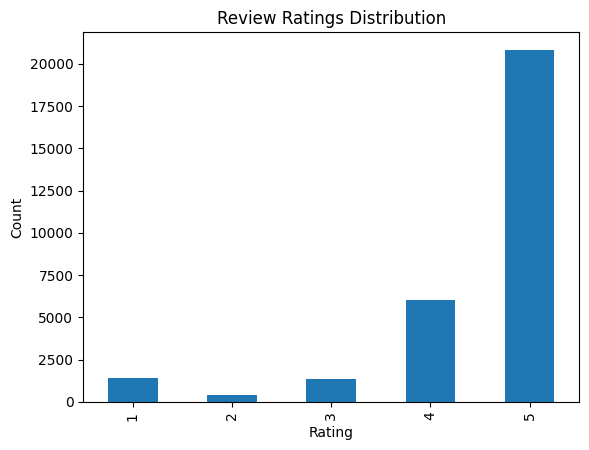

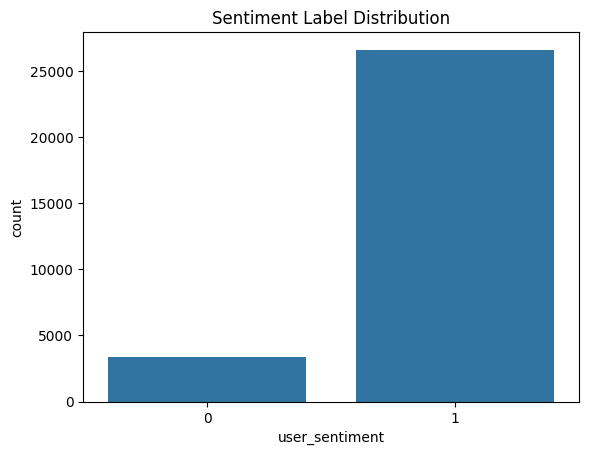

In [15]:
print('Data shape:', df_reviews.shape)
df_reviews.info()
df_reviews.describe(include='all')

print('Sentiment distribution:')
print(df_reviews['user_sentiment'].value_counts())

df_reviews['reviews_rating'].value_counts().sort_index().plot(kind='bar', title='Review Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

sns.countplot(x='user_sentiment', data=df_reviews)
plt.title('Sentiment Label Distribution')
plt.show()

In [16]:
df_reviews[(df_reviews["user_sentiment"]==1) & (df_reviews["reviews_rating"]<4)][["reviews_title","reviews_text", "reviews_rating"]]

,reviews_title,reviews_text,reviews_rating
9,Don't buy,Got as a surprise for my husband there is noth...,1
11,Waste of Money,Purchased this thinking it would have some sor...,1
14,Disappointed,First time purchase of this type of product. M...,1
18,Pretty nice,I bought this because it had better reviews th...,3
54,New formula is terrible,I used (and loved) this product for several ye...,1
...,...,...,...
29050,Didn't Do Much For Dryness,I received this product from Influenster. I ab...,3
29051,Not the best,I used this product for a month straight befor...,3
29053,clay conditioning,Got this item as a compliment from influenster...,3
29054,Eh,I am not in love with the conditioner. The cla...,3


In [17]:
df_reviews[(df_reviews["user_sentiment"]==0) & (df_reviews["reviews_rating"]>=4)][["reviews_title","reviews_text", "reviews_rating"]]

,reviews_title,reviews_text,reviews_rating
92,hydrating but not too heavy,It hydrates my skin. It is not too thick and h...,4
96,This product has made a real difference on my ...,In only a week I can see the difference in my ...,4
100,Noticed a difference in just two weeks!,This product has made my skin smoother and sup...,4
106,Very rich cream,I like to use this cream on my neck and collar...,4
117,Not greasy,I finally found a moisturizing product that wi...,4
...,...,...,...
29818,Great Product,I received a complimentary sample of this prod...,5
29855,Great,This has prolonged the color in my hair! Not o...,5
29858,Makes my hair soft and shiny without excess oil!,This conditioner makes my hair very soft witho...,5
29862,Great Conditioner,This conditioner has become a staple in my hai...,5


In [18]:
df_reviews.loc[(df_reviews["user_sentiment"]==1) & (df_reviews["reviews_rating"]<4), "user_sentiment"] = 0

In [19]:
df_reviews.loc[(df_reviews["user_sentiment"]==0) & (df_reviews["reviews_rating"]>=4), "user_sentiment"] = 1

In [20]:
df_reviews["user_sentiment"].value_counts()

,count
user_sentiment,
1,26850
0,3149


In [21]:
def filter_products(productId, pos=1):
    review_count = df_reviews[(df_reviews.id==productId) & (df_reviews.user_sentiment==pos)]['brand'].count()
    return review_count

In [22]:
#group the dataframe by product id and view the # of pos review / neg reviews count
df_custom =  df_reviews.groupby('id', as_index=False)['user_sentiment'].count()
df_custom["pos_review_count"] =  df_custom.id.apply(lambda id: filter_products(id, 1))
df_custom["neg_review_count"] =  df_custom.id.apply(lambda id: filter_products(id, 0))

In [23]:
df_custom.head(10)

,id,user_sentiment,pos_review_count,neg_review_count
0,AV13O1A8GV-KLJ3akUyj,1,1,0
1,AV14LG0R-jtxr-f38QfS,2,2,0
2,AV16khLE-jtxr-f38VFn,27,10,17
3,AV1YGDqsGV-KLJ3adc-O,348,274,74
4,AV1YIch7GV-KLJ3addeG,1,1,0
5,AV1YlENIglJLPUi8IHsX,17,14,3
6,AV1YmBrdGV-KLJ3adewb,18,17,1
7,AV1YmDL9vKc47QAVgr7_,89,74,15
8,AV1Ymf_rglJLPUi8II2v,34,34,0
9,AV1Yn94nvKc47QAVgtst,25,24,1


In [24]:
#sort the product by sentiment % - postive reviews / total number of reviews
df_custom['sentiment %'] = np.round((df_custom['pos_review_count']/df_custom['user_sentiment'])*100,2)
df_custom.sort_values(by='sentiment %', ascending=False)[:20]

,id,user_sentiment,pos_review_count,neg_review_count,sentiment %
0,AV13O1A8GV-KLJ3akUyj,1,1,0,100.0
1,AV14LG0R-jtxr-f38QfS,2,2,0,100.0
4,AV1YIch7GV-KLJ3addeG,1,1,0,100.0
8,AV1Ymf_rglJLPUi8II2v,34,34,0,100.0
11,AV1Ynb3bglJLPUi8IJxJ,5,5,0,100.0
13,AV1Yo6FPglJLPUi8IK3u,1,1,0,100.0
10,AV1YnUMYglJLPUi8IJpK,1,1,0,100.0
247,AVpfml2VilAPnD_xe0m6,1,1,0,100.0
245,AVpfmVnVLJeJML43AMqC,6,6,0,100.0
45,AVpe5Mv4ilAPnD_xQQyy,4,4,0,100.0


In [25]:
#removing null from username
df_reviews = df_reviews[~df_reviews.reviews_username.isnull()]

In [26]:
#Merging the reviews_text and reviews_title for analysis
df_reviews["reviews_title"] = df_reviews["reviews_title"].fillna('')
df_reviews["reviews_full_text"] = df_reviews[['reviews_title', 'reviews_text']].agg('. '.join, axis=1).str.lstrip('. ')

In [27]:
df_reviews[["reviews_full_text", "user_sentiment"]].sample(10)

,reviews_full_text,user_sentiment
4359,"Hoover Happy!. I am a mom, homemaker and profe...",1
14013,"Love These!. With 5 kids including a toddler, ...",1
2749,Worth the wait. It's been many years since the...,1
21909,tastes like parmesan - for real. The best and ...,1
14428,clorox. i like the fact that i can wipe down a...,1
24401,"Great Story, Action, and Sound. I saw this mov...",1
16325,My favorite lip balm with color. This is so ni...,1
13239,I love Clorox Wipes!. I love using Clorox Wipe...,1
3936,I Would Buy This Folder Again.. The folder org...,1
8202,Cleaning. we use clorox wipes everyday and wil...,1


In [28]:
# to clean the text
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub("\[\s*\w*\s*\]", "", text)
    dictionary = "abc".maketrans('', '', string.punctuation)
    text = text.translate(dictionary)
    text = re.sub("\S*\d\S*", "", text)

    return text

In [29]:
df_clean = df_reviews[['id','name', 'reviews_full_text', 'user_sentiment']]

In [30]:
df_clean["reviews_text"] = df_clean.reviews_full_text.apply(lambda x: clean_text(x))

In [31]:
# to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [32]:
stop_words = set(stopwords.words('english'))

def remove_stopword(text):
    words = [word for word in text.split() if word.isalpha() and word not in stop_words]
    return " ".join(words)

In [33]:
## lemitization
lemmatizer = WordNetLemmatizer()

def lemma_text(text):
    word_pos_tags = nltk.pos_tag(word_tokenize(remove_stopword(text))) # Get position tags
    # Map the position tag and lemmatize the word/token
    words =[lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(words)

In [38]:
df_clean["reviews_text_cleaned"] = df_clean.reviews_text.apply(lambda x: lemma_text(x))

In [39]:
df_clean.head()

,id,name,reviews_full_text,user_sentiment,reviews_text,reviews_text_cleaned
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome. i love this album. it's very goo...,1,just awesome i love this album its very good m...,awesome love album good hip hop side current p...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor. This review was collected a...,1,good good flavor this review was collected as ...,good good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor.,1,good good flavor,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Disappointed. I read through the reviews on he...,0,disappointed i read through the reviews on her...,disappoint read review look buy one couple lub...
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Irritation. My husband bought this gel for us....,0,irritation my husband bought this gel for us t...,irritation husband buy gel u gel caused irrita...


In [40]:
#function to collect the n-gram frequency of words
def get_top_n_ngram( corpus, n_gram_range ,n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0)
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [41]:
X = df_clean['reviews_text_cleaned']
y = df_clean['user_sentiment']

In [42]:
#TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=650, max_df=0.9, min_df=7, binary=True,
                                   ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(df_clean['reviews_text_cleaned'])

y= df_clean['user_sentiment']

In [43]:
# splitting into test and train
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, random_state=42, test_size=0.25)

In [44]:
# SMOTE for class imbalance
counter = Counter(y_train)
print('Before',counter)

sm = SMOTE()

# transform the dataset
X_train, y_train = sm.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After',counter)

Before Counter({1: 20087, 0: 2365})
After Counter({1: 20087, 0: 20087})


In [45]:
from sklearn import metrics
import pickle

In [46]:
class ModelBuilder:
    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test


    def train_model(self):
        self.model.fit(self.x_train,self.y_train)
        return self.model.predict(self.x_test)

    def evaluate_model(self, y_pred_class):
        print("\n")
        print("*"*30)
        self.result_metrics = self.evaluate_metrics(y_pred_class)
        print("*"*30)
        print("\n")

        self.classification_report(y_pred_class)
        print("*"*30)
        print("\n")
        self.confusion_matrix(y_pred_class)

        print("*"*30)
        print("\n")

        metrics.RocCurveDisplay.from_estimator(self.model, self.x_test, self.y_test)

        return self.result_metrics

    def evaluate_metrics(self, y_pred_class):
        result_metrics = []
        accuracy = metrics.accuracy_score(self.y_test, y_pred_class)
        precision = metrics.precision_score(self.y_test, y_pred_class)
        recall = metrics.recall_score(self.y_test, y_pred_class)
        f1score = metrics.f1_score(self.y_test, y_pred_class)
        y_pred_prob = self.model.predict_proba(self.x_test)[:,1]
        roc_auc = metrics.roc_auc_score(self.y_test, y_pred_prob)

        print(f"Accuracy is : {accuracy*100:.1f}%")
        print(f"Precision is : {precision*100:.1f}%")
        print(f"Recall is : {recall*100:.1f}%")
        print(f"F1 Score is : {f1score*100:.1f}%")
        print(f"Roc-Auc Score is:{roc_auc*100:.1f}%")

        result_metrics.append(accuracy)
        result_metrics.append(precision)
        result_metrics.append(recall)
        result_metrics.append(f1score)
        result_metrics.append(roc_auc)
        return result_metrics

    def confusion_matrix(self, y_pred_class):
        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_class)
        self.plot_confusion_matrix(confusion_matrix,[0,1])


    def plot_confusion_matrix(self, data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(data/np.sum(data), annot=True, cmap="Blues", fmt=".2%")

        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)

        ax.set(ylabel="True Values", xlabel="Predicted Values")
        plt.show()

    def classification_report(self, y_pred_class):
        print(metrics.classification_report(self.y_test, y_pred_class))


In [47]:
# Logistic Regression model.
logreg = LogisticRegression(random_state=42, max_iter=100,solver='liblinear', class_weight="balanced")
lr_ci_modebuilder = ModelBuilder(logreg, X_train, X_test, y_train, y_test)

In [48]:
# Train and Predict the Test Labels
y_pred_class  = lr_ci_modebuilder.train_model()



******************************
Accuracy is : 88.3%
Precision is : 96.7%
Recall is : 90.0%
F1 Score is : 93.2%
Roc-Auc Score is:90.0%
******************************


              precision    recall  f1-score   support

           0       0.46      0.73      0.56       770
           1       0.97      0.90      0.93      6714

    accuracy                           0.88      7484
   macro avg       0.71      0.81      0.75      7484
weighted avg       0.91      0.88      0.89      7484

******************************




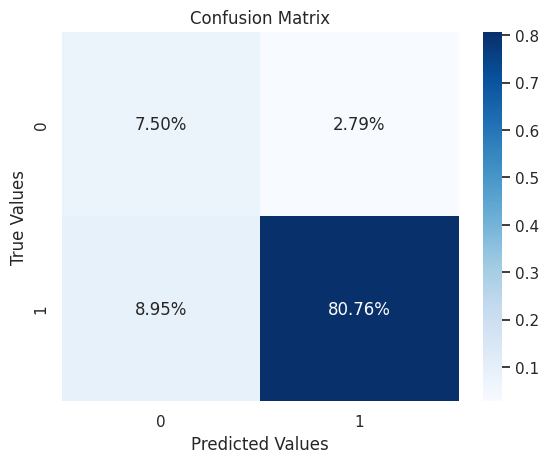

******************************




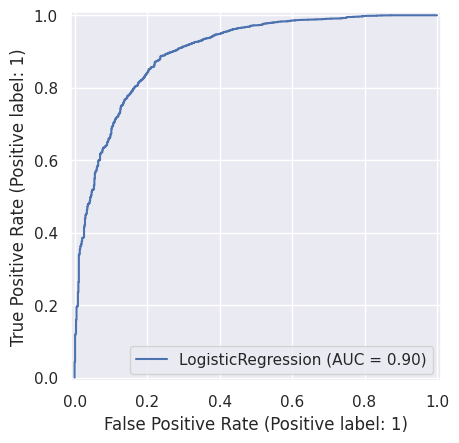

In [49]:
lr_metrics = lr_ci_modebuilder.evaluate_model(y_pred_class)

In [50]:
## Naive Bayes
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=1.0)
mnb_modebuilder = ModelBuilder(mnb, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 80.9%
Precision is : 97.6%
Recall is : 80.7%
F1 Score is : 88.4%
Roc-Auc Score is:89.5%
******************************


              precision    recall  f1-score   support

           0       0.33      0.83      0.47       770
           1       0.98      0.81      0.88      6714

    accuracy                           0.81      7484
   macro avg       0.65      0.82      0.68      7484
weighted avg       0.91      0.81      0.84      7484

******************************




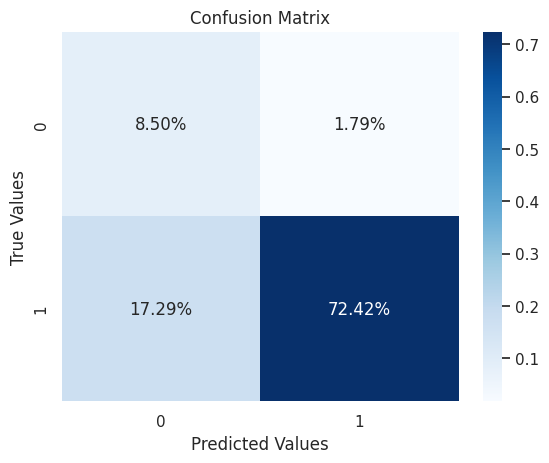

******************************




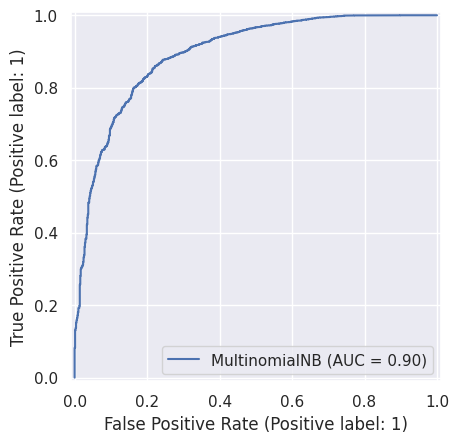

In [51]:
# Train and Predict the Test Labels
y_pred_class  = mnb_modebuilder.train_model()
nb_metrics = mnb_modebuilder.evaluate_model(y_pred_class)

In [52]:
## Random Forest

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

rf = RandomForestClassifier(oob_score=True, random_state=42, criterion="gini")

params = {
    'max_depth': [2,3,5,10],
    'min_samples_leaf': [5,10,20,50],
    'n_estimators': [10, 25, 50, 100]
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="f1")

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 64 candidates, totalling 256 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [5, 10, 20, 50],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='f1', verbose=1)

In [53]:
rf_best = grid_search.best_estimator_
rf_modebuilder = ModelBuilder(rf_best, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 80.4%
Precision is : 96.3%
Recall is : 81.2%
F1 Score is : 88.2%
Roc-Auc Score is:85.9%
******************************


              precision    recall  f1-score   support

           0       0.31      0.73      0.43       770
           1       0.96      0.81      0.88      6714

    accuracy                           0.80      7484
   macro avg       0.64      0.77      0.66      7484
weighted avg       0.90      0.80      0.84      7484

******************************




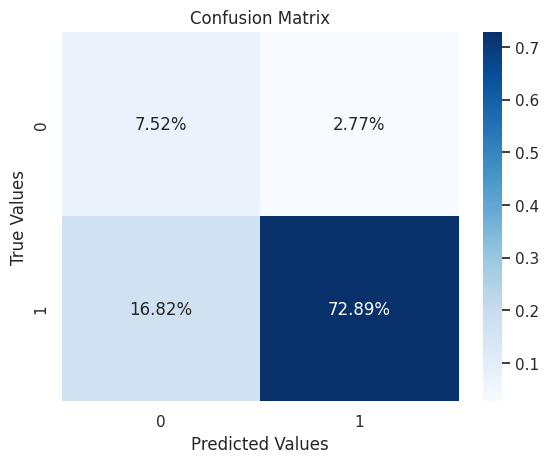

******************************




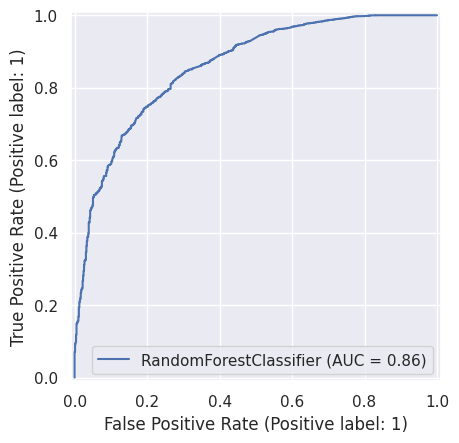

In [54]:
# Train and Predict the Test Labels
y_pred_class  = rf_modebuilder.train_model()
rf_metrics = rf_modebuilder.evaluate_model(y_pred_class)

In [56]:
## XGBoost Classifier
import xgboost as xgb

xgclf = xgb.XGBClassifier(learning_rate=0.15, max_depth=10, random_state=42) #based on the tuned parameters
xg_modebuilder = ModelBuilder(xgclf, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 90.8%
Precision is : 95.8%
Recall is : 93.9%
F1 Score is : 94.8%
Roc-Auc Score is:90.7%
******************************


              precision    recall  f1-score   support

           0       0.55      0.64      0.59       770
           1       0.96      0.94      0.95      6714

    accuracy                           0.91      7484
   macro avg       0.75      0.79      0.77      7484
weighted avg       0.92      0.91      0.91      7484

******************************




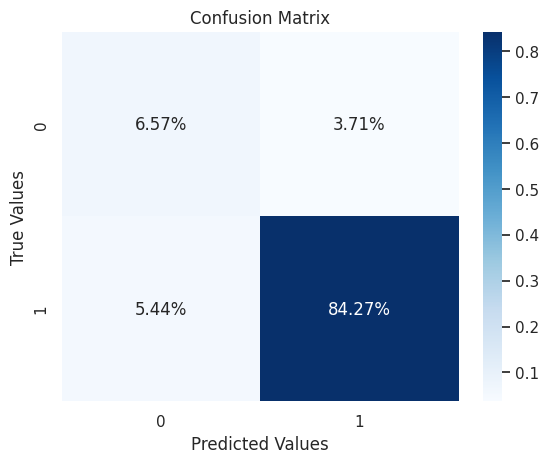

******************************




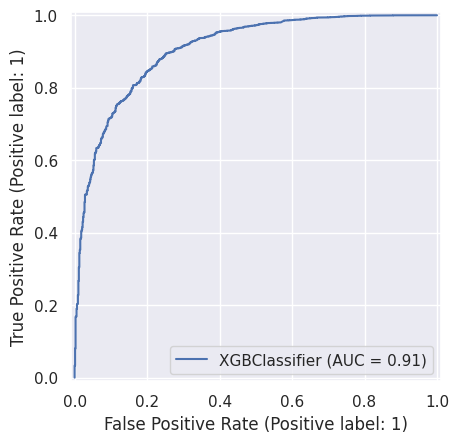

In [57]:
# Train and Predict the Test Labels
y_pred_class  = xg_modebuilder.train_model()
xg_metrics = xg_modebuilder.evaluate_model(y_pred_class)

In [58]:
xg_metrics

[0.9084714056654195,
 0.9577828397873956,
 0.939380399165922,
 0.9484923678472066,
 np.float64(0.9067869425778272)]

In [60]:
# Creating a table which contain all the metrics

metrics_table = {'Metric': ['Accuracy','Precision','Recall',
                       'F1Score','Auc Score'],
        'Logistic Regression': lr_metrics,
        'Naive Bayes': nb_metrics,
         'Random Forrest': rf_metrics,
        'XG Boost': xg_metrics
        }

df_metrics = pd.DataFrame(metrics_table ,columns = ['Metric', 'Logistic Regression', 'Naive Bayes','Random Forrest',
                                                    'XG Boost'] )

df_metrics

,Metric,Logistic Regression,Naive Bayes,Random Forrest,XG Boost
0,Accuracy,0.882549,0.809193,0.804115,0.908471
1,Precision,0.966576,0.975873,0.963440,0.957783
2,Recall,0.900209,0.807268,0.812481,0.939380
3,F1Score,0.932213,0.883600,0.881545,0.948492
4,Auc Score,0.900478,0.895326,0.859213,0.906787


In [61]:
def save_object(obj, filename):
    filename = "pickle/"+filename+'.pkl'
    pickle.dump(obj, open(filename, 'wb'))

In [63]:
import os
if not os.path.exists('pickle'):
    os.makedirs('pickle')
save_object(xgclf, 'sentiment-classification-xg-boost-model')
save_object(tfidf_vectorizer, 'tfidf-vectorizer')
save_object(df_clean, 'cleaned-data')

In [64]:
### Recommendation System

In [65]:
### User based Recommendation System

In [66]:
df_recommendation = df_reviews[["id", "name", "reviews_rating", "reviews_username"]]

In [109]:
#splitting the train and test
train, test = train_test_split(df_recommendation, test_size=0.25, random_state=42)

In [130]:
print(train.shape)
print(test.shape)

(22452, 4)
(7484, 4)


In [69]:
product_column = "id"
user_column = "reviews_username"
value_column = "reviews_rating"

In [70]:
# Create a Pivot table for Username and Products
df_pivot = pd.pivot_table(train,index=user_column, columns = product_column, values = value_column).fillna(0)
df_pivot.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08dallas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
09mommy11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.11E+24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [72]:
# The products not rated by user is marked as 1 for prediction.
dummy_train[value_column] = dummy_train[value_column].apply(lambda x: 0 if x>=1 else 1)

In [73]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
dummy_train = pd.pivot_table(dummy_train,index=user_column, columns = product_column, values = value_column).fillna(1)
dummy_train.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
08dallas,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
09mommy11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1.11E+24,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [74]:
#using cosine_similarity function to compute the distance.

from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

user_correlation = cosine_similarity(df_pivot)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

[[1.        0.        0.        ... 0.        0.9486833 0.       ]
 [0.        1.        1.        ... 0.        0.        0.       ]
 [0.        1.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.9486833 0.        0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]
(19427, 19427)


In [75]:
#filtering out the user_correlation that are negatively correlated
user_correlation[user_correlation<0]=0
user_correlation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.9486833,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.9486833, 0.       , 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

In [76]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 1.20913332, ..., 2.9103958 , 0.        ,
        0.54410719],
       [0.        , 0.        , 3.12347524, ..., 3.00158035, 0.        ,
        0.        ],
       [0.        , 0.        , 3.12347524, ..., 3.00158035, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.88675135],
       [0.        , 0.        , 0.        , ..., 1.64034869, 0.        ,
        0.57353933],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.88675135]])

In [77]:
# As we are interested in products that are not rated by the user, we multiply with dummy train to make it zero
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,1.209133,13.576034,0.0,0.0,0.0,2.256552,0.440415,3.136671,...,0.449467,0.422577,0.000000,0.0,0.0,0.0,2.121320,2.910396,0.0,0.544107
01impala,0.0,0.0,3.123475,15.578925,0.0,0.0,0.0,0.000000,2.340823,2.119252,...,1.421338,0.267261,0.000000,0.0,0.0,0.0,0.000000,3.001580,0.0,0.000000
02dakota,0.0,0.0,3.123475,15.578925,0.0,0.0,0.0,0.000000,2.340823,2.119252,...,1.421338,0.267261,0.000000,0.0,0.0,0.0,0.000000,3.001580,0.0,0.000000
02deuce,0.0,0.0,3.123475,15.578925,0.0,0.0,0.0,0.000000,2.340823,2.119252,...,1.421338,0.267261,0.000000,0.0,0.0,0.0,0.000000,3.001580,0.0,0.000000
0325home,0.0,0.0,0.000000,11.344965,0.0,0.0,0.0,6.010227,6.937603,2.097953,...,0.000000,0.445435,3.535534,0.0,0.0,0.0,2.236068,0.000000,0.0,2.886751


In [78]:
# Take the user ID as input.
user_input = input("Enter your user name")
print(user_input)

Enter your user name08dallas
08dallas


In [79]:
recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations

,08dallas
id,
AVpfPaoqLJeJML435Xk9,24.411263
AVpfRTh1ilAPnD_xYic2,20.730190
AVpf3VOfilAPnD_xjpun,8.481302
AVpe41TqilAPnD_xQH3d,6.582782
AVpf0eb2LJeJML43EVSt,5.064475
AVpfBrUZilAPnD_xTUly,4.573207
AVpfJP1C1cnluZ0-e3Xy,3.679464
AV1l8zRZvKc47QAVhnAv,3.535534
AVpf5olc1cnluZ0-tPrO,3.395675


In [80]:
#display the top 20 product id, name and similarity_score
final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,24.411263
2464,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,20.730190
3315,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,8.481302
9689,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),6.582782
10262,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),5.064475
10899,AVpfBrUZilAPnD_xTUly,"Coty Airspun Face Powder, Translucent Extra Co...",4.573207
11022,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,3.679464
12585,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,3.535534
13067,AVpf5olc1cnluZ0-tPrO,Chester's Cheese Flavored Puffcorn Snacks,3.395675
13196,AVpf7I3i1cnluZ0-tnL6,Mrs. Meyer's174 Lemon Verbena Laundry Scent Bo...,2.886751


In [81]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1795, 4)

In [82]:
# convert into the user-product matrix.
common_user_based_matrix = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85lisa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,19417,19418,19419,19420,19421,19422,19423,19424,19425,19426
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0


In [84]:
user_correlation_df[user_column] = df_pivot.index
user_correlation_df.set_index(user_column,inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,19417,19418,19419,19420,19421,19422,19423,19424,19425,19426
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0
01impala,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02dakota,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02deuce,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0325home,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0


In [85]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [86]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [87]:
user_correlation_df_3 = user_correlation_df_2.T

In [88]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 7.79183531, 0.        , ..., 0.        , 0.        ,
        2.29277852],
       [0.        , 0.        , 0.        , ..., 3.12347524, 0.        ,
        0.        ],
       [0.        , 1.31227896, 0.        , ..., 0.        , 0.        ,
        1.49255579],
       ...,
       [0.        , 0.        , 0.        , ..., 3.12347524, 0.        ,
        0.        ],
       [0.        , 1.86700847, 0.        , ..., 0.        , 0.        ,
        1.74077656],
       [0.        , 0.        , 0.        , ..., 3.12347524, 0.        ,
        0.        ]])

In [89]:
dummy_test = common.copy()

dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test,index=user_column, columns = product_column, values = value_column).fillna(0)

In [90]:
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85lisa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
dummy_test.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85lisa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [93]:
#calculate RMSE

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [94]:
common_ = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)

In [95]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [96]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.09137486961924


In [97]:
### Item based Recommendation System

In [98]:
df_pivot = pd.pivot_table(train,
    index=product_column,
    columns=user_column,
    values=value_column
)

df_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [100]:
df_subtracted.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [102]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [103]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.00568296, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00946238],
       [0.        , 0.        , 0.        , ..., 0.00716692, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00756991]])

In [104]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.009141,0.0,0.0,0.0,0.00000,0.000000,0.005833,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.019346,0.005683,0.0,0.000000
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.004556,...,0.0,0.092658,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.007593,...,0.0,0.154430,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.006074,...,0.0,0.123544,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
0325home,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00132,0.003772,0.001795,...,0.0,0.000000,0.003785,0.0,0.0,0.0,0.005955,0.000000,0.0,0.009462


In [105]:
# Take the user ID as input.
user_input = input("Enter your user name")
print(user_input)

Enter your user name08dallas
08dallas


In [106]:
# Recommending the Top 5 products to the user.
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
item_recommendations

,08dallas
id,
AVpfE7puilAPnD_xUcCW,0.530077
AVpfNc9cLJeJML434tza,0.286131
AVpe9W4D1cnluZ0-avf0,0.139978
AVpfPaoqLJeJML435Xk9,0.049780
AVpe41TqilAPnD_xQH3d,0.048034
AVpe59io1cnluZ0-ZgDU,0.042933
AVpf7I3i1cnluZ0-tnL6,0.040555
AVpe8xjUilAPnD_xRkxC,0.035741
AVpe7GIELJeJML43yZfu,0.032604


In [107]:
item_final_recommendations = pd.DataFrame({'product_id': item_recommendations.index, 'similarity_score' : item_recommendations})
item_final_recommendations.reset_index(drop=True)

pd.merge(item_final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfE7puilAPnD_xUcCW,Bilbao Nightstand Gray Oak - South Shore,0.530077
5,AVpfNc9cLJeJML434tza,Feit 60-Watt A19 Gu24 Base Led Light Bulb - So...,0.286131
11,AVpe9W4D1cnluZ0-avf0,Hoover174 Platinum Collection153 Lightweight B...,0.139978
267,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,0.049780
2731,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),0.048034
3304,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,0.042933
3798,AVpf7I3i1cnluZ0-tnL6,Mrs. Meyer's174 Lemon Verbena Laundry Scent Bo...,0.040555
3819,AVpe8xjUilAPnD_xRkxC,The Honest Company Laundry Detergent,0.035741
3833,AVpe7GIELJeJML43yZfu,Eagle Fat Free Sweetened Condensed Milk,0.032604
3847,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),0.007387


In [110]:
common =  test[test.id.isin(train.id)]
common.shape

(7472, 4)

In [111]:
common.head(4)

,id,name,reviews_rating,reviews_username
25787,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,5,youknowhowitgoes
12627,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,ashleydale00
15778,AVpf63aJLJeJML43F__Q,"Burt's Bees Lip Shimmer, Raisin",3,angie1108
1138,AV1YmDL9vKc47QAVgr7_,"Aussie Aussome Volume Shampoo, 13.5 Oz",5,falisha


In [112]:
common_item_based_matrix = common.pivot_table(index=product_column, columns=user_column, values=value_column)

In [113]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
item_correlation_df[product_column] = df_subtracted.index
item_correlation_df.set_index(product_column,inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
list_name = common.id.tolist()

In [116]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [117]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [118]:
df_subtracted

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVpfshNsLJeJML43CB8q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpfthSailAPnD_xg3ON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpftikC1cnluZ0-p31V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02163973, 3.        , 0.        , ..., 0.        , 0.0097714 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00756991, ..., 0.        , 0.        ,
        0.00946238]])

In [120]:
dummy_test = common.copy()
dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test, index=product_column, columns=user_column, values=value_column).fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [121]:
common_ = pd.pivot_table(common,index=product_column, columns=user_column, values=value_column)

In [122]:
from sklearn.preprocessing import MinMaxScaler

X  = common_item_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [123]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [124]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5547511636482922


In [125]:
# saving the correlation matrix of user based recommender
save_object(user_final_rating, "user_final_rating")

In [126]:
### Top Product Recommendations - Recommendation of 20 products and filtering by sentiment model

In [127]:
def get_sentiment_recommendations(user):
    if (user in user_final_rating.index):
        # get the product recommedation using the trained ML model
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        temp = df_clean[df_clean.id.isin(recommendations)]
        #temp["reviews_text_cleaned"] = temp["reviews_text"].apply(lambda x: self.preprocess_text(x))
        #transfor the input data using saved tf-idf vectorizer
        X =  tfidf_vectorizer.transform(temp["reviews_text_cleaned"].values.astype(str))
        temp["predicted_sentiment"]= xgclf.predict(X)
        temp = temp[['name','predicted_sentiment']]
        temp_grouped = temp.groupby('name', as_index=False).count()
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp.predicted_sentiment==1)]["predicted_sentiment"].count())
        temp_grouped["total_review_count"] = temp_grouped['predicted_sentiment']
        temp_grouped['pos_sentiment_percent'] = np.round(temp_grouped["pos_review_count"]/temp_grouped["total_review_count"]*100,2)
        return temp_grouped.sort_values('pos_sentiment_percent', ascending=False)
    else:
        print(f"User name {user} doesn't exist")

In [128]:
#testing the above fuction using one of the users that's trained on.
get_sentiment_recommendations(user_input)

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
0,"Batherapy Natural Mineral Bath Sport Liquid, 1...",2,2,2,100.00
2,"Cetaphil Gentle Skin Cleanser, 2oz",7,7,7,100.00
5,Clorox Disinfecting Wipes Value Pack Scented 1...,8525,8476,8525,99.43
4,Clorox Disinfecting Bathroom Cleaner,2039,2001,2039,98.14
15,Planes: Fire Rescue (2 Discs) (includes Digita...,1142,1092,1142,95.62
14,Olay Regenerist Deep Hydration Regenerating Cream,634,602,634,94.95
17,Stargate (ws) (ultimate Edition) (director's C...,186,176,186,94.62
19,The Resident Evil Collection 5 Discs (blu-Ray),845,796,845,94.20
16,Red (special Edition) (dvdvideo),672,616,672,91.67
18,The Honest Company Laundry Detergent,20,18,20,90.00


In [131]:
#get the top 5
get_sentiment_recommendations(user_input)[:5]

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
0,"Batherapy Natural Mineral Bath Sport Liquid, 1...",2,2,2,100.00
2,"Cetaphil Gentle Skin Cleanser, 2oz",7,7,7,100.00
5,Clorox Disinfecting Wipes Value Pack Scented 1...,8525,8476,8525,99.43
4,Clorox Disinfecting Bathroom Cleaner,2039,2001,2039,98.14
15,Planes: Fire Rescue (2 Discs) (includes Digita...,1142,1092,1142,95.62


In [132]:
#testing the above fuction on the user that doesn't exists or a new user
get_sentiment_recommendations("test123")

User name test123 doesn't exist
